In [187]:
import urllib.request
import json
import os
import pandas as pd
import xml.etree.ElementTree as ET

In [188]:
import re

df = pd.read_csv('data/all_data.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
df.drop(681, inplace = True)

def const(str):
    if str == None:
        return None
    else:
        result = re.sub('<.{1,7}>', '' , str)
        return result

#df.summary = list(map(const, list(df.summary)))

mpa = map(const, list(df.summary))

#list(map(lambda x : x., list(df.summary)))
#list(mpa)

from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words 

l = list(df.summary)
#for i in list(df.summary):
 #   print(type(i))

for index, element in enumerate(l):
    if type(element) != str:
        print(index, element)


df.summary = list(mpa)

summary = list(df.summary) 
summary = list(map(lambda x: x.lower(), summary)) # convert all in lower characthers
vectorizer = TfidfVectorizer(stop_words=get_stop_words('english'))
dfm = vectorizer.fit_transform(summary)
dfm

dfm_summary = []
for i in range(len(summary)):
    dfm_summary.append(dfm[i,:])

print(dfm_summary[0])
df['dfm_summary'] = dfm_summary
print(type(df['dfm_summary'][0]))
df
# for summ in summary:
#     try:
#         summ = summ.lower()
#         vectorizer = TfidfVectorizer(stop_words=get_stop_words('english'))
#         #print(summ)
#         dfm = vectorizer.fit_transform(summ)
#         print(dfm)
#         dfm_summary.append(dfm)
#     except:
#         dfm_summary.append(None)


c:\Users\zazzo\.virtualenvs\Text_as_data-P4hExxh8\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


  (0, 6080)	0.17009047505755062
  (0, 8714)	0.12167469190331266
  (0, 13102)	0.07832206001533441
  (0, 8709)	0.1351704208076618
  (0, 10312)	0.05342686028745445
  (0, 13703)	0.10796844838801593
  (0, 6860)	0.08401337638507043
  (0, 3597)	0.10084408691199087
  (0, 4520)	0.1389510655167512
  (0, 6627)	0.08426863869826737
  (0, 4877)	0.10614569509099839
  (0, 10715)	0.09602725277244642
  (0, 2987)	0.14866614971201095
  (0, 5265)	0.09725628571524611
  (0, 7358)	0.18894543896733357
  (0, 9237)	0.09061669827868414
  (0, 7009)	0.20779174630361616
  (0, 6074)	0.11964142399534754
  (0, 11424)	0.07523306328501464
  (0, 13098)	0.08112839181824003
  (0, 13602)	0.16905278282962305
  (0, 14055)	0.5642629973635488
  (0, 11970)	0.0721415535285454
  (0, 11431)	0.0869668431628897
  (0, 2992)	0.10182269671074158
  (0, 9728)	0.09562996041519839
  (0, 3955)	0.06564431461958518
  (0, 999)	0.08934322555435596
  (0, 2892)	0.03806690578745962
  (0, 8143)	0.09562996041519839
  (0, 2989)	0.07487114743514466
  (0

,bill number,subjects,summary,policy_area,latest_action,cosponsor_D_perc,cosponsor_R_perc,dfm_summary
0,4996,{'legislativeSubjects': [{'name': 'Administrat...,Bankruptcy Administration Improvement Act of ...,Finance and Financial Sector,2021-01-12,0.600000,0.400000,"(0, 6080)\t0.17009047505755062\n (0, 8714)\..."
1,8906,{'legislativeSubjects': [{'name': 'Child healt...,Lifespan Respite Care Reauthorization Act of ...,Health,2021-01-05,0.000000,1.000000,"(0, 6670)\t0.1084456063112379\n (0, 9750)\t..."
2,8810,{'legislativeSubjects': [{'name': 'Advisory bo...,National Landslide Preparedness Act This bill...,Emergency Management,2021-01-05,1.000000,0.000000,"(0, 5307)\t0.04851030790668721\n (0, 9919)\..."
3,8611,{'legislativeSubjects': [{'name': 'Congression...,Designates the facility of the United States ...,Government Operations and Politics,2021-01-05,0.500000,0.500000,"(0, 4204)\t0.1506954468966445\n (0, 11042)\..."
4,8354,{'legislativeSubjects': [{'name': 'Criminal in...,Servicemembers and Veterans Initiative Act of...,"Civil Rights and Liberties, Minority Issues",2021-01-05,0.714286,0.285714,"(0, 9957)\t0.07752991800966937\n (0, 4914)\..."
...,...,...,...,...,...,...,...,...
915,1037,{'legislativeSubjects': [{'name': 'District of...,(Sec. 1) This bill authorizes the National Em...,Public Lands and Natural Resources,2018-11-03,0.875000,0.125000,"(0, 6719)\t0.13372747092553\n (0, 2809)\t0...."
916,6896,{'legislativeSubjects': [{'name': 'Congression...,United States Parole Commission Extension Act...,Crime and Law Enforcement,2018-10-31,1.000000,0.000000,"(0, 6380)\t0.17504501997271874\n (0, 11596)..."
917,6758,{'legislativeSubjects': [{'name': 'Congression...,Study of Underrepresented Classes Chasing Eng...,Commerce,2018-10-31,0.600000,0.400000,"(0, 8536)\t0.1487843643772415\n (0, 14324)\..."
918,1595,{'legislativeSubjects': [{'name': 'Bank accoun...,Hizballah International Financing Prevention ...,International Affairs,2018-10-25,0.461538,0.538462,"(0, 10627)\t0.05516944643551206\n (0, 8967)..."


In [189]:
from sklearn.utils import shuffle
y_D = list(df['cosponsor_D_perc'])
x = dfm #list(df['dfm_summary'])
def create_class(x):
    if x<=0.35:
        return 'D'
    elif 0.35<x<0.65:
         return 'D/R'
    else:
        return 'R'

#x, y_D = shuffle(x, y_D, random_state=0)
y_D = list(map(create_class, y_D)) 


test_size = 0.2

y_D_train = y_D[:int(len(y_D)*(1-test_size))]
y_D_test = y_D[int(len(y_D)*(1-test_size)):]
x_train = x[:int(x.shape[0]*(1-test_size)), :]
x_test = x[int(x.shape[0]*(1-test_size)):, :]

print(x.shape[1])
print(f'lenght of y_D_train: {len(y_D_train)} \n lenght of y_D_test: {len(y_D_test)} \n lenght of x_train: {x_train.shape} \n lenght of x_test: {x_test.shape}')

14903
lenght of y_D_train: 735 
 lenght of y_D_test: 184 
 lenght of x_train: (735, 14903) 
 lenght of x_test: (184, 14903)


In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt', 
    max_depth = 14000, random_state = 18).fit(x_train, y_D_train)

y_D_pred = rf.predict(x_test)
accuracy = rf.score(x_test, y_D_pred)

print(f'accuracy score: {accuracy_score(y_D_test, y_D_pred)}')

import matplotlib.pyplot as plt




# reversefactor = dict(zip(range(3),definitions))
# y_test = np.vectorize(reversefactor.get)(y_D_test)
# y_pred = np.vectorize(reversefactor.get)(y_D_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_D_test, y_D_pred, rownames=['Actual party'], colnames=['Predicted party']))

accuracy score: 0.532608695652174
Predicted party   D  D/R   R
Actual party                
D                39   12  12
D/R              17   22  18
R                19    8  37


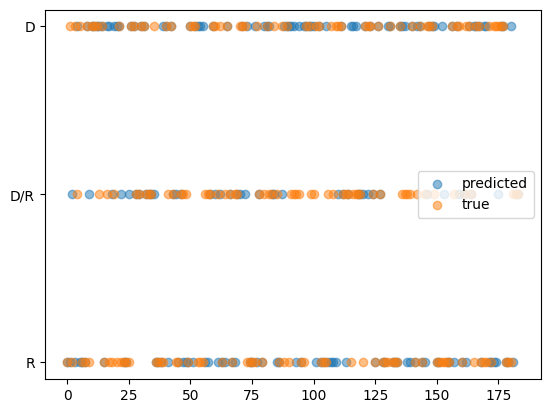

In [195]:
plt.scatter(range(0,len(y_D_pred)), y_D_pred, label = 'predicted', alpha = .5)
plt.scatter(range(0,len(y_D_pred)), y_D[int(len(y_D)*(1-test_size)):], label = 'true', alpha = .5)
plt.legend()


In [132]:
def congress_deco(output_format='json') -> object:
                
                def get_congress(func):
                        
                        print(f'Decorating: {func.__name__}')
                        
                        def wrapper(*args, **kwargs):
                                
                                try:
                                        
                                        url, hdr = func(*args, **kwargs)
                                        
                                        req = urllib.request.Request(url, headers=hdr)
                                        req.get_method = lambda: 'GET'
                                        response = urllib.request.urlopen(req, timeout=5)
                                        
                                        output = response.read()
                                        
                                        if output_format == 'json':
                                                
                                                output = json.loads(output)
                                                
                                        if output_format == 'html':
                                                
                                                root = ET.ElementTree(ET.fromstring(output)).getroot()
                                                
                                                output = [node.text for node in root.findall('.//pre')]
                                        
                                        return output
                                
                                except Exception as e:
                                        
                                        print(e)
                                
                        return wrapper
                
                return get_congress
        
        
@congress_deco(output_format='json')
def get_congress_data(query:str, *args, api_key="6ej9da2smGykG5a2jMYcHY5sWWaznOXPxfZeEz83") -> dict: #os.getenv('US_GOV_api')
                
                hdr = {
                        # specifying requested encoding
                        'Cache-Control': 'no-cache',
                        'charset': 'UTF-8',
                        'X-Api-Key': api_key,
                        'User-Agent': 'Mozilla/5.0'
                        }
                
                BASE_URL = 'https://api.congress.gov/v3/'
                
                query_url = BASE_URL + query
                
                if args: # concatenate variable arguments to url
                                query_url += '&' + '&'.join(args)
                                
                return (query_url, hdr)
        
@congress_deco(output_format='html')
def get_bill_text(query:str, api_key="6ej9da2smGykG5a2jMYcHY5sWWaznOXPxfZeEz83") -> str: #os.getenv('US.GOV_API')
                
                hdr = {
                        # specifying requested encoding
                        'Cache-Control': 'no-cache',
                        'charset': 'UTF-8',
                        'User-Agent': 'Mozilla/5.0'
                        }
                
                return (query, hdr)

Decorating: get_congress_data
Decorating: get_bill_text


In [5]:
def get_congress_data(query:str, *args, api_key= "6ej9da2smGykG5a2jMYcHY5sWWaznOXPxfZeEz83") -> dict: #os.getenv('US_GOV_API')
                
                hdr = {
                        # specifying requested encoding
                        'Cache-Control': 'no-cache',
                        'charset': 'UTF-8',
                        'X-Api-Key': api_key,
                        'User-Agent': 'Mozilla/5.0'
                        }
                
                BASE_URL = 'https://api.congress.gov/v3/'
                
                query_url = BASE_URL + query
                
                if args: # concatenate variable arguments to url
                                query_url += '&' + '&'.join(args)
                                
                return (query_url, hdr)

In [6]:
def get_congress_data(query, *args, api_key="6ej9da2smGykG5a2jMYcHY5sWWaznOXPxfZeEz83"): #os.getenv('US_GOV_api')
                
    try:
        BASE_URL = 'https://api.congress.gov/v3/'
        
        hdr = {
            #specifying requested encoding
            'Cache-Control': 'no-cache',
            'charset': 'UTF-8',
            'X-Api-Key': api_key
            }
                        
        query_url = BASE_URL + query
                        
        if args: # concatenate variable arguments to url
            query_url += '&' + '&'.join(args)
                        
        req = urllib.request.Request(query_url, headers=hdr)
        req.get_method = lambda: 'GET'
        response = urllib.request.urlopen(req)

        string_resp = response.read()
                        
        return json.loads(string_resp)
                        
    except Exception as e:
                        
        print(e)

In [133]:
bills_df = pd.read_csv('data/bills2.csv')
bills_recent = bills_df[bills_df['congress'] => 115]

def get_root_url(url):
    return url.replace('https://api.congress.gov/v3/', '').replace('?format=json', '')

#metadata = get_congress_data(get_root_url(bills_df.iloc[181712]['url']))


#get_congress_data(get_root_url(bills_recent.iloc[1]['url']))
text_url = get_congress_data(
                                get_root_url(row['url']) + '/text')['textVersions'][0]['formats'][0]['url']

In [12]:
txt_url = get_congress_data(
    get_root_url(bills_recent.iloc[1]['url']) + '/text')['textVersions'][0]['formats'][0]['url']

#get_bill_text(txt_url)

cosponsors = get_congress_data(get_root_url(metadata['bill']['cosponsors']['url']) + "?", 'limit=250')
                                cosponsor_D = 0
                                cosponsor_R = 0
                                cosponsor_df = pd.DataFrame()
                                for cosponsor in cosponsors['cosponsors']:
                                        cosponsor_party = cosponsor['party']
                                        print(f"cosponsponsor party: {cosponsor_party}")
                                        if cosponsor_party == "D":
                                                cosponsor_D += 1 
                                        if cosponsor_party == "R":
                                                cosponsor_R += 1
                                        print((cosponsor_D, cosponsor_R))
                                        cosposor_name = cosponsor['firstName'] + ' ' + cosponsor['lastName']
                                        cosponsor_party = cosponsor['party']
                                        cosponsor_df = cosponsor_df.append({'cosponsor_name': cosposor_name, 'cosponsor_party': cosponsor_party, 'number': bill_number}, ignore_index=True)
                                #number = int(output_l[0]['metadata']['bill']['number'])
                                if (cosponsor_D + cosponsor_R)!= 0:
                                        print((cosponsor_D + cosponsor_R))
                                        cosponsor_D_perc = cosponsor_D/(cosponsor_D + cosponsor_R)
                                        cosponsor_R_perc = cosponsor_R/(cosponsor_D + cosponsor_R)

In [139]:
bills_recent.iloc[2]

Unnamed: 0                                                                 2
congress                                                                 116
latestAction               {'actionDate': '2021-01-13', 'text': 'Became P...
number                                                                  5076
originChamber                                                         Senate
originChamberCode                                                          S
title                      A bill to authorize the Sergeant at Arms and D...
type                                                                       S
updateDate                                                        2022-03-10
updateDateIncludingText                                 2022-03-10T16:14:09Z
url                        https://api.congress.gov/v3/bill/116/s/5076?fo...
Name: 181715, dtype: object

In [170]:
FINAL_DF = bills_recent[bills_recent['latestAction'].str.contains('Public Law')]

In [142]:
metadata = get_congress_data(get_root_url(bills_recent.iloc[2]['url']))
metadata['bill']

{'actions': {'count': 17,
  'url': 'https://api.congress.gov/v3/bill/116/s/5076/actions?format=json'},
 'congress': 116,
 'introducedDate': '2020-12-20',
 'latestAction': {'actionDate': '2021-01-13',
  'text': 'Became Public Law No: 116-344.'},
 'laws': [{'number': '116-344', 'type': 'Public Law'}],
 'number': '5076',
 'originChamber': 'Senate',
 'policyArea': {'name': 'Congress'},
 'sponsors': [{'bioguideId': 'B000575',
   'firstName': 'Roy',
   'fullName': 'Sen. Blunt, Roy [R-MO]',
   'isByRequest': 'N',
   'lastName': 'Blunt',
   'party': 'R',
   'state': 'MO',
   'url': 'https://api.congress.gov/v3/member/B000575?format=json'}],
 'subjects': {'count': 5,
  'url': 'https://api.congress.gov/v3/bill/116/s/5076/subjects?format=json'},
 'summaries': {'count': 4,
  'url': 'https://api.congress.gov/v3/bill/116/s/5076/summaries?format=json'},
 'textVersions': {'count': 3,
  'url': 'https://api.congress.gov/v3/bill/116/s/5076/text?format=json'},
 'title': 'A bill to authorize the Sergeant a

In [180]:
output_l = []
list_df_cosposors = []

for i, row in FINAL_DF.iterrows():

        try:
                        metadata = get_congress_data(get_root_url(row['url']))
                        # TODO: get infos from metadata dictionary, like sponsors, originChamber, polyArea, title
                        bill_number = metadata['bill']['number']
                        policy_area = metadata['bill']['policyArea']['name']
                        if 'cosponsors' in metadata['bill'].keys():
                                cosponsors = get_congress_data(get_root_url(metadata['bill']['cosponsors']['url']) + "?", 'limit=250')
                                cosponsor_D = 0
                                cosponsor_R = 0
                                cosponsor_df = pd.DataFrame()
                                for cosponsor in cosponsors['cosponsors']:
                                        cosponsor_party = cosponsor['party']
                                        #print(f"cosponsponsor party: {cosponsor_party}")
                                        if cosponsor_party == "D":
                                                cosponsor_D += 1 
                                        if cosponsor_party == "R":
                                                cosponsor_R += 1
                                        #print((cosponsor_D, cosponsor_R))
                                        cosposor_name = cosponsor['firstName'] + ' ' + cosponsor['lastName']
                                        cosponsor_party = cosponsor['party']
                                        cosponsor_df = cosponsor_df.append({'cosponsor_name': cosposor_name, 'cosponsor_party': cosponsor_party, 'number': bill_number}, ignore_index=True)
                                #number = int(output_l[0]['metadata']['bill']['number'])
                                if (cosponsor_D + cosponsor_R)!= 0:
                                        #print((cosponsor_D + cosponsor_R))
                                        cosponsor_D_perc = cosponsor_D/(cosponsor_D + cosponsor_R)
                                        cosponsor_R_perc = cosponsor_R/(cosponsor_D + cosponsor_R)
                                cosponsor_D = 0
                                cosponsor_R = 0
                                cosponsor_df = pd.DataFrame()
                        else :
                                cosponsor_D_perc = 0
                                cosponsor_R_perc = 0

                        #print(cosponsor_D_perc, cosponsor_R_perc)
                        
                        latest_action = metadata['bill']['latestAction']['actionDate']

                        print('Bill number done for df line: ', i)

                        text_url = get_congress_data(
                                get_root_url(row['url']) + '/text')['textVersions'][0]['formats'][0]['url']
                        print('URL text done for df line: ', i)

                        summary_meta = get_congress_data(
                                get_root_url(row['url']) + '/summaries')['summaries']
                        print(summary_meta)

                        summary = summary_meta[-1]['text']

                        print('Summary done for df line: ', i)

                        # subjects = get_congress_data(
                        #         get_root_url(row['url']) + '/subjects')['subjects']
                        # print('Subjects done for df line: ', i)
                        
                        # related_bills = get_congress_data(
                        #         get_root_url(row['url']) + '/relatedbills')
                        # print('Related bills done for df line: ', i)
                        #TODO: optional, extract information from this. Otherwise 
                        
                        #TODO: extract: amendments, committees, cosponsors(!), titles                        

                        list_df_cosposors.append(cosponsor_df)
                        output_l.append({'bill number': bill_number, 'text_url': text_url, 
                                        'policy_area': policy_area,'summary' : summary, 'latest_action': latest_action,
                                        'cosponsor_D_perc': cosponsor_D_perc, 'cosponsor_R_perc': cosponsor_R_perc})

        except Exception as e:
               print(e)

df_ouput_cosposors = pd.concat(list_df_cosposors)
output_l

Bill number done for df line:  181713
URL text done for df line:  181713
[{'actionDate': '2019-12-18', 'actionDesc': 'Introduced in House', 'text': ' <p><b>Jimmy Carter National Historical Park Redesignation Act</b></p> <p>This bill redesignates the Jimmy Carter National Historic Site in Georgia as the Jimmy Carter National Historical Park.</p>', 'updateDate': '2020-05-19T22:45:24Z', 'versionCode': '00'}, {'actionDate': '2020-12-14', 'actionDesc': 'Reported to House', 'text': ' <p><b>Jimmy Carter National Historical Park Redesignation Act</b></p> <p>This bill redesignates the Jimmy Carter National Historic Site in Georgia as the Jimmy Carter National Historical Park.</p>', 'updateDate': '2021-05-24T16:27:44Z', 'versionCode': '07'}, {'actionDate': '2020-12-17', 'actionDesc': 'Passed House', 'text': ' <p><b>Jimmy Carter National Historical Park Redesignation Act</b></p> <p>This bill redesignates the Jimmy Carter National Historic Site in Georgia as the Jimmy Carter National Historical Pa

KeyboardInterrupt: 

In [1]:
final_df = pd.DataFrame.from_records(output_l)
final_df.iloc[5]['summary']

NameError: name 'pd' is not defined

In [183]:
final_df = pd.DataFrame.from_records(output_l)
final_df

,bill number,text_url,policy_area,summary,latest_action,cosponsor_D_perc,cosponsor_R_perc
0,5472,https://www.congress.gov/116/bills/hr5472/BILL...,Public Lands and Natural Resources,<p><b>Jimmy Carter National Historical Park R...,2021-01-13,0.307692,0.692308
1,5126,https://www.congress.gov/116/bills/hr5126/BILL...,Public Lands and Natural Resources,<p><b>Direct Enhancement of Snapper Conservat...,2021-01-13,0.500000,0.500000
2,5076,https://www.congress.gov/116/bills/s5076/BILLS...,Congress,<p>This bill authorizes the Sergeant at Arms ...,2021-01-13,0.000000,0.000000
3,4704,https://www.congress.gov/116/bills/hr4704/BILL...,Health,<p><b>Advancing Research to Prevent Suicide A...,2021-01-13,0.812500,0.187500
4,4508,https://www.congress.gov/116/bills/hr4508/BILL...,International Affairs,<p><b>Malala Yousafzai Scholarship Act</b></p...,2021-01-13,0.531250,0.468750
5,4044,https://www.congress.gov/116/bills/hr4044/BILL...,Environmental Protection,<p><b>Protect and Restore America's Estuaries...,2021-01-13,0.769231,0.230769
6,371,https://www.congress.gov/116/bills/s371/BILLS-...,Finance and Financial Sector,<p><b>Building Up Independent Lives and Dream...,2021-01-13,0.500000,0.500000
7,3250,https://www.congress.gov/116/bills/hr3250/BILL...,Public Lands and Natural Resources,<p><b>Julius Rosenwald and the Rosenwald Scho...,2021-01-13,0.813953,0.186047
8,3153,https://www.congress.gov/116/bills/hr3153/BILL...,"Science, Technology, Communications",<p><b>Expanding Findings for Federal Opioid R...,2021-01-13,0.640000,0.360000
9,2744,https://www.congress.gov/116/bills/hr2744/BILL...,International Affairs,<p><b>USAID Branding Modernization Act</b></p...,2021-01-13,0.666667,0.333333


In [158]:
pd.read_csv('data/summary_data.csv')

,Unnamed: 0,Introduced in House,Reported to House,Passed House,Passed Senate,Public Law,bill,title,Introduced in Senate,House agreed to Senate amendment,Reported to Senate,"Reported to House, Part I",Conference report filed in House,Senate agreed to House amendment
0,0,<p><b>Jimmy Carter National Historical Park R...,<p><b>Jimmy Carter National Historical Park R...,<p><b>Jimmy Carter National Historical Park R...,<p><b>Jimmy Carter National Historical Park R...,<p><b>Jimmy Carter National Historical Park R...,5472,Jimmy Carter National Historical Park Redesign...,NaN,NaN,NaN,NaN,NaN,NaN
1,1,<p><b>Direct Enhancement of Snapper Conservat...,<p><b>Direct Enhancement of Snapper Conservat...,<p><b>Direct Enhancement of Snapper Conservat...,<p><b>Direct Enhancement of Snapper Conservat...,<p><b>Direct Enhancement of Snapper Conservat...,5126,DESCEND Act of 2020,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,<p>This bill authorizes the Sergeant at Arms ...,<p>This bill authorizes the Sergeant at Arms ...,<p>This bill authorizes the Sergeant at Arms ...,5076,A bill to authorize the Sergeant at Arms and D...,<p>This bill authorizes the Sergeant at Arms ...,NaN,NaN,NaN,NaN,NaN
3,3,<p><b>Advancing Research to Prevent Suicide A...,<p><b>Advancing Research to Prevent Suicide A...,<p><b>Advancing Research to Prevent Suicide A...,<p><b>Advancing Research to Prevent Suicide A...,<p><b>Advancing Research to Prevent Suicide A...,4704,Advancing Research to Prevent Suicide Act,NaN,<p><b>Advancing Research to Prevent Suicide A...,NaN,NaN,NaN,NaN
4,4,<p><b>Malala Yousafzai Scholarship Act</b></p...,NaN,<p><b>Malala Yousafzai Scholarship Act</b></p...,<p><b>Malala Yousafzai Scholarship Act</b></p...,<p><b>Malala Yousafzai Scholarship Act</b></p...,4508,Malala Yousafzai Scholarship Act,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,<p><b>Improving Care for Vulnerable Older Cit...,NaN,NaN,NaN,NaN,9057,Improving Care for Vulnerable Older Citizens a...,NaN,NaN,NaN,NaN,NaN,NaN
96,96,NaN,NaN,<p>This bill designates the community-based o...,<p>This bill designates the community-based o...,<p>This bill designates the community-based o...,900,A bill to designate the community-based outpat...,<p>This bill designates the community-based o...,NaN,NaN,NaN,NaN,<p>This bill designates the community-based o...
97,97,NaN,NaN,<p><b>Secret Service Overtime Pay Extension A...,<p><b>Secret Service Overtime Pay Extension A...,<p><b>Secret Service Overtime Pay Extension A...,5036,Secret Service Overtime Pay Extension Act,<p><b>Secret Service Overtime Pay Extension A...,NaN,NaN,NaN,NaN,NaN
98,98,NaN,NaN,NaN,NaN,<p>Designates the facility of the United Stat...,4684,A bill to designate the facility of the United...,Designates the facility of the United States P...,NaN,NaN,NaN,NaN,NaN


In [21]:
for i in output_l:
    print(i["cosponsor_R_perc"], i["cosponsor_D_perc"])
    


0.0 1.0
0.0 1.0
0 0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


In [18]:

row = bills_recent.iloc[5]

metadata = get_congress_data(get_root_url(row['url']))
                        # TODO: get infos from metadata dictionary, like sponsors, originChamber, polyArea, title
bill_number = metadata['bill']['number']
policy_area = metadata['bill']['policyArea']['name']
if 'cosponsors' in metadata['bill'].keys():
                                cosponsors = get_congress_data(get_root_url(metadata['bill']['cosponsors']['url']) + "?", 'limit=250')
                                cosponsor_D = 0
                                cosponsor_R = 0
                                cosponsor_df = pd.DataFrame()
                                for cosponsor in cosponsors['cosponsors']:
                                        cosponsor_party = cosponsor['party']
                                        print(f"cosponsponsor party: {cosponsor_party}")
                                        if cosponsor_party == "D":
                                                cosponsor_D += 1 
                                        if cosponsor_party == "R":
                                                cosponsor_R += 1
                                        print((cosponsor_D, cosponsor_R))
                                        cosposor_name = cosponsor['firstName'] + ' ' + cosponsor['lastName']
                                        cosponsor_party = cosponsor['party']
                                        cosponsor_df = cosponsor_df.append({'cosponsor_name': cosposor_name, 'cosponsor_party': cosponsor_party, 'number': bill_number}, ignore_index=True)
                                #number = int(output_l[0]['metadata']['bill']['number'])
                                if (cosponsor_D + cosponsor_R)!= 0:
                                        print((cosponsor_D + cosponsor_R))
                                        cosponsor_D_perc = cosponsor_D/(cosponsor_D + cosponsor_R)
                                        cosponsor_R_perc = cosponsor_R/(cosponsor_D + cosponsor_R)

else:
                                cosponsor_D_perc = 0
                                cosponsor_R_perc = 0
                                cosponsor_df = pd.DataFrame()


print(cosponsor_D_perc, cosponsor_R_perc)


cosponsponsor party: D
(1, 0)
cosponsponsor party: R
(1, 1)
cosponsponsor party: D
(2, 1)
cosponsponsor party: R
(2, 2)
cosponsponsor party: D
(3, 2)
cosponsponsor party: D
(4, 2)
cosponsponsor party: D
(5, 2)
cosponsponsor party: D
(6, 2)
cosponsponsor party: D
(7, 2)
cosponsponsor party: D
(8, 2)
cosponsponsor party: D
(9, 2)
cosponsponsor party: D
(10, 2)
cosponsponsor party: D
(11, 2)
cosponsponsor party: D
(12, 2)
cosponsponsor party: R
(12, 3)
cosponsponsor party: D
(13, 3)
cosponsponsor party: D
(14, 3)
cosponsponsor party: D
(15, 3)
cosponsponsor party: D
(16, 3)
cosponsponsor party: R
(16, 4)
cosponsponsor party: D
(17, 4)
cosponsponsor party: R
(17, 5)
cosponsponsor party: R
(17, 6)
cosponsponsor party: D
(18, 6)
cosponsponsor party: D
(19, 6)
cosponsponsor party: D
(20, 6)
26
0.7692307692307693 0.23076923076923078


/var/folders/ct/yw5th2lx0d75cqds32p3ws6c0000gn/T/ipykernel_2716/26229471.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cosponsor_df = cosponsor_df.append({'cosponsor_name': cosposor_name, 'cosponsor_party': cosponsor_party, 'number': bill_number}, ignore_index=True)
/var/folders/ct/yw5th2lx0d75cqds32p3ws6c0000gn/T/ipykernel_2716/26229471.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cosponsor_df = cosponsor_df.append({'cosponsor_name': cosposor_name, 'cosponsor_party': cosponsor_party, 'number': bill_number}, ignore_index=True)
/var/folders/ct/yw5th2lx0d75cqds32p3ws6c0000gn/T/ipykernel_2716/26229471.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cosponsor_df = cosponsor_df.append({'cosponsor_name': cospo

In [69]:
# output_l[0]['metadata']['bill']['cosponsors']['url']
cosponsors = get_congress_data(get_root_url(output_l[0]['metadata']['bill']['cosponsors']['url']) + "?", 'limit=250')



In [120]:
get_congress_data(get_root_url(bills_recent.iloc[11812]['url']))['bill']['latestAction']

{'actionDate': '2019-06-07',
 'text': 'Referred to the Subcommittee on Europe, Eurasia, Energy and the Environment.'}

In [86]:
cosponsor_df = pd.DataFrame()

for cosponsor in cosponsors['cosponsors']:
    consposor_name = cosponsor['firstName'] + ' ' + cosponsor['lastName']
    cosponsor_party = cosponsor['party']
    number = str(output_l[0]['metadata']['bill']['number'])
    cosponsor_df = cosponsor_df.append({'cosponsor_name': consposor_name, 'cosponsor_party': cosponsor_party, 'number': number}, ignore_index=True)

cosponsor_df

,cosponsor_name,cosponsor_party,number
0,Tom Graves,R,5472.0
1,Austin Scott,R,5472.0
2,JOHN LEWIS,D,5472.0
3,Rick Allen,R,5472.0
4,A. Ferguson,R,5472.0
5,Henry Johnson,D,5472.0
6,Barry Loudermilk,R,5472.0
7,David Scott,D,5472.0
8,Earl Carter,R,5472.0
9,Lucy McBath,D,5472.0


In [88]:
outputdf = pd.DataFrame.from_records(output_l)
bills_recent.merge(cosponsor_df, on='number', how="inner")

,Unnamed: 0,congress,latestAction,number,originChamber,originChamberCode,title,type,updateDate,updateDateIncludingText,url,cosponsor_name,cosponsor_party
0,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Tom Graves,R
1,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Austin Scott,R
2,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,JOHN LEWIS,D
3,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Rick Allen,R
4,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,A. Ferguson,R
5,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Henry Johnson,D
6,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Barry Loudermilk,R
7,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,David Scott,D
8,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Earl Carter,R
9,0,116,"{'actionDate': '2021-01-13', 'text': 'Became P...",5472,House,H,Jimmy Carter National Historical Park Redesign...,HR,2022-10-28,2022-10-28T01:46:16Z,https://api.congress.gov/v3/bill/116/hr/5472?f...,Lucy McBath,D


In [80]:
bills_recent.columns

Index(['Unnamed: 0', 'congress', 'latestAction', 'number', 'originChamber',
       'originChamberCode', 'title', 'type', 'updateDate',
       'updateDateIncludingText', 'url'],
      dtype='object')